In [26]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.insert(0, ".")

import asyncio
from src.main import run_round
from src.file_util import load_data, save_data, safe_load_yaml

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


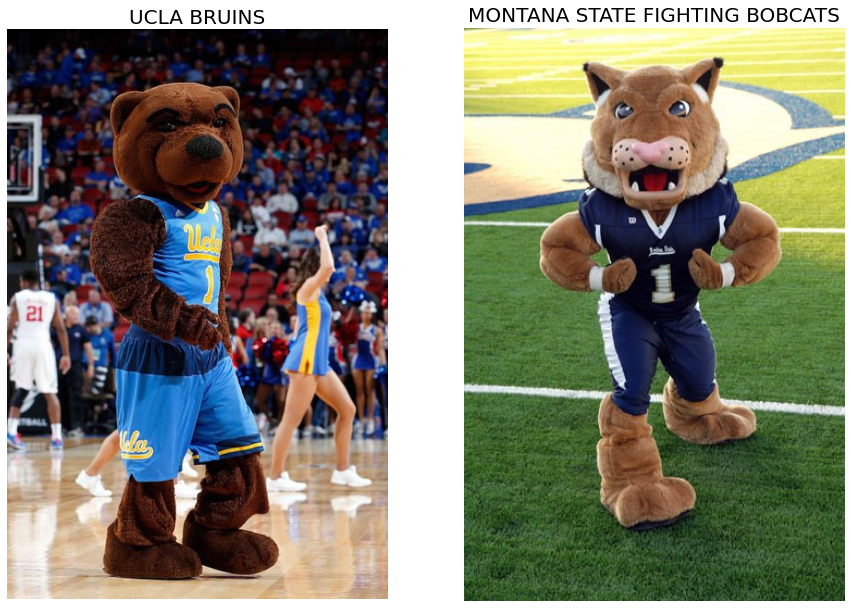

ToggleButtons(options=('UCLA', 'MONTANA STATE', 'RANDOM'), value='UCLA')

Button(description='Submit', icon='check', style=ButtonStyle())

In [4]:
# enter round 1 through 6
asyncio.create_task(run_round(1))

In [28]:
df2 = load_data(region="south", rnd=3)

df2.head(16)

,Unnamed: 0,team_name,seed,region,round
effective_seed,,,,,
1,0,tcu,9,south,3
2,0,delaware,15,south,3
3,0,longwood,14,south,3
4,0,uab,12,south,3


In [12]:
import pandas as pd

df = pd.read_csv("data/2023/east_1.csv")

df.loc[df["effective_seed"] == 1, "team_name"][0]

'purdue'

In [14]:
df

,effective_seed,team_name,seed,region,round
0,1,purdue,1,east,1
1,2,marquette,2,east,1
2,3,baylor,3,east,1
3,4,tennessee,4,east,1
4,5,iowa_state,5,east,1
5,6,saint_marys,6,east,1
6,7,northwestern,7,east,1
7,8,memphis,8,east,1
8,9,west_virginia,9,east,1
9,10,auburn,10,east,1


In [25]:
import json
for effective_seed in range(1, 17):
    print(effective_seed)
    team = df.loc[df["effective_seed"] == effective_seed, "team_name"].tolist()[0]
    if "[" in team:
        team = "/".join(json.loads(team.replace("'", '"')))
    print(team)

1
purdue
2
marquette
3
baylor
4
tennessee
5
iowa_state
6
saint_marys
7
northwestern
8
memphis
9
west_virginia
10
auburn
11
nc_state/arizona_state
12
charleston
13
kent_state
14
kennesaw_state
15
colgate
16
howard/southeast_missouri_state


In [16]:
df.loc[df["effective_seed"] == 2, "team_name"]

1    marquette
Name: team_name, dtype: object